In [2]:
import numpy as np
import sympy as sp
import math
from scipy.interpolate import griddata
import matplotlib.pyplot as plt


from sympy import solve, Eq, symbols, re

lam1,lam2 ,p, coeffIAT2 = symbols('lam1 lam2 p coeffIAT2')

coeffIAT2 = 16
coeffST2_arr = [ 1.21, 4, 25, 64]

#coeffIST2 = 16
#coeffIAT2_arr = [ 1.21, 4, 25, 64]

In [65]:
def compute_kurtosis_H2(lam1 , lam2, p) :

    return ((24*p/lam1**4 + 24*(1-p)/lam2**4)/((2*p/lam1**2 + 2*(1-p)/lam2**2) - ((p/lam1+ (1-p)/lam2)**2))**2) - 3

In [66]:
def calculatecoeff_var(lam1, lam2, p) :
    dist_mean =  p/lam1+ (1-p)/lam2
    dist_var = (2*p/lam1**2 + 2*(1-p)/lam2**2) - dist_mean**2
    dist_sd = abs(np.sqrt(dist_var))
    
    if (dist_sd / dist_mean) >= 1 :
        return(dist_sd/dist_mean)
    else :
        print("Please check your inputs. Coefficient of variance < 1")
        return -100

In [67]:
#Implementing the Tarasov H2/H2/1 RT
def Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr) :
    WTarasov_arr = []
    for k in range(min(len(p_arr), len(q_arr))) : 
        a_0 = (lam1_arr[k]*lam2_arr[k])
        a_1 = p_arr[k]*lam1_arr[k] + (1-p_arr[k])*lam2_arr[k]
        b_0 = (mu1_arr[k]*mu2_arr[k])
        b_1 = q_arr[k]*mu1_arr[k] + (1-q_arr[k])*mu2_arr[k]

        c_0 = a_0*b_1 - a_1*b_0 - a_0*(mu1_arr[k]+mu2_arr[k]) + b_0*(lam1_arr[k] + lam2_arr[k])
        c_1 = -a_1*b_1 -a_0 - b_0  + (lam1_arr[k] + lam2_arr[k])*(mu1_arr[k] + mu2_arr[k])
        c_2 = lam1_arr[k] + lam2_arr[k] - mu1_arr[k] - mu2_arr[k]
        
        x = symbols('x')
        expr = x**3-c_2*x**2-c_1*x-c_0


        sol = solve(expr)
        #print(sol)
        
        #calculate wait time in queue Wq
        
        Wq = (-1/re(sol[0])) + (-1/re(sol[1])) - (1/mu1_arr[k]) - (1/mu2_arr[k]) 
        
        #calculate response time in queue W

        W = Wq + (q_arr[k]/mu1_arr[k]+ (1-q_arr[k])/mu2_arr[k])
        WTarasov_arr.append(W)

        if k == 0 :
            print("In order lam1 lam2 p", lam1_arr[k], lam2_arr[k], p_arr[k])
            print("In order mu1 mu2 q", mu1_arr[k], mu2_arr[k], q_arr[k])
            print("RT ", W)

    return WTarasov_arr

Lengths for parameter vectors of IAT :  3000 3000 3000
In order lam1 lam2 p 0.677938761047955 0.02073213181585131 0.9780803280470414
In order mu1 mu2 q 1.2983622941075077 0.6863789463255439 0.6653673702152019
RT  2.94152589909389
Lengths for parameter vectors of IAT :  3000 3000 3000
In order lam1 lam2 p 0.7683329525322673 0.024031533996087595 0.9702685658549588
In order mu1 mu2 q 22.32836479288825 0.38905527145928226 0.6217787644513224
RT  5.81431766948193
Lengths for parameter vectors of IAT :  3000 3000 3000
In order lam1 lam2 p 1.0402265325772375 0.03033554959803689 0.9519212440733166
In order mu1 mu2 q 29.551569791893932 0.07451402626179464 0.92782547761201
RT  18.4038786473031
Lengths for parameter vectors of IAT :  3000 3000 3000
In order lam1 lam2 p 3.4907789321822613 0.04223574394749562 0.9053645360139365
In order mu1 mu2 q 2.3991766051477637 0.018177442072015635 0.9893181601728334
RT  33.0660208908563
False
False


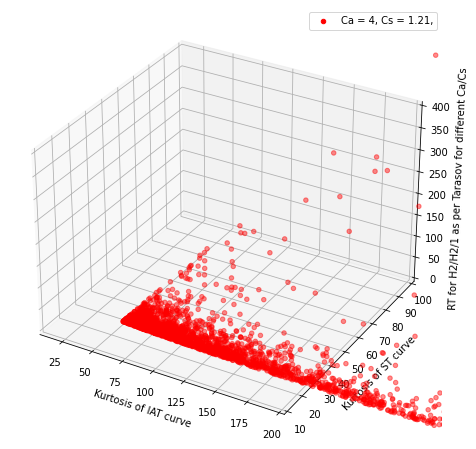

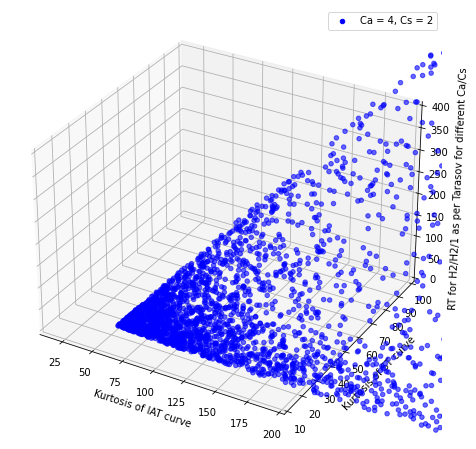

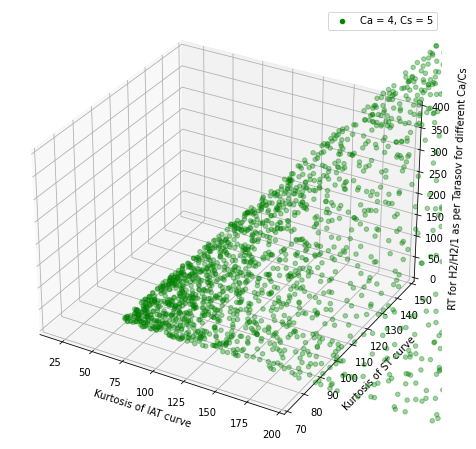

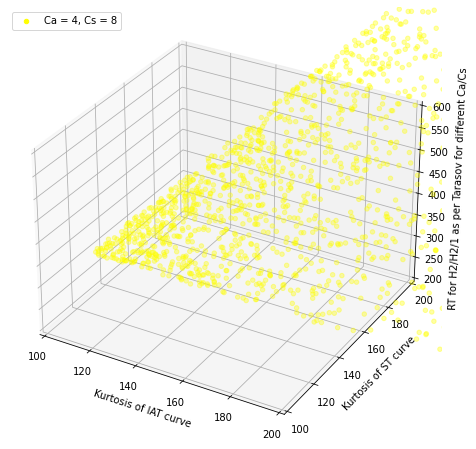

In [68]:
#Fixed IAT, changing ST CV
W_exact = []

for coeffST2 in coeffST2_arr :
    
    i = 0
    j = 0
    #For IAT where mean service time is 5
    p_arr= []
    lam1_arr = []
    lam2_arr = []
    lam_kurt_arr = []
    

    q_arr = []
    mu1_arr = []
    mu2_arr = []
    mu_kurt_arr = []
   
    

    while i < 3000 :
        p = np.random.rand()
        lam2 = 0.4*(2.0*p + 1.41421*math.sqrt(-p*(coeffIAT2 - 1.0)*(p - 1.0)) - 2.0)/(coeffIAT2*p + p - 2.0)  
        lam1 = (0.8*p + 0.56568*math.sqrt(p*(-coeffIAT2*p + coeffIAT2 + p - 1.0)))/(coeffIAT2*p - coeffIAT2 + p + 1.0)

        if lam1 <= 0 or lam2 <= 0 :
            continue
        #print("lam1 :",lam1, "lam2 :", lam2, "p :",p)

        q = np.random.rand()*0.5 + 0.5
        mu2 = (2*q + math.sqrt(2)*math.sqrt(-q*(coeffST2 - 1)*(q - 1)) - 2)/(coeffST2*q + q - 2)  # Multiplying by 10 to scale the random numbers between 0 and 20
        mu1 = (2*q + math.sqrt(2)*math.sqrt(q*(-coeffST2*q + coeffST2 + q - 1)))/(coeffST2*q - coeffST2 + q + 1)

        if mu1 <= 0 or mu2 <= 0:
            continue
        
        if calculatecoeff_var(lam1, lam2, p) >=1 and calculatecoeff_var(mu1, mu2, q) >= 1 :
            p_arr.append(p)
            lam1_arr.append(lam1)
            lam2_arr.append(lam2)
            #if calculatecoeff_var(lam1, lam2, p) > 0  :
            lam_kurt_arr.append(compute_kurtosis_H2(lam1, lam2, p))

            q_arr.append(q)
            mu1_arr.append(mu1)
            mu2_arr.append(mu2)
            #if calculatecoeff_var(mu1, mu2, q) > 0  :
            mu_kurt_arr.append(compute_kurtosis_H2(mu1, mu2, q))
        

        i += 1

    
    print("Lengths for parameter vectors of IAT : ", len(p_arr), len(lam1_arr), len(lam2_arr))
    #print(mu_coeff_var_arr)
    W_exact = Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr)
    
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot( projection='3d')
    
    #plt.scatter(lam_kurt_arr, W_exact)
    
    if coeffST2 == 1.21 :
        #plt.scatter(mu_kurt_arr, W_exact, color = 'red', label = 'Ca = 4, Cs = 1.21,')
        ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'red', label = 'Ca = 4, Cs = 1.21,')
        ax1.set_xlim(10, 200)
        ax1.set_ylim(10,100)
        ax1.set_zlim(0,400)
        
    elif coeffST2 == 4 :
        #plt.scatter(mu_kurt_arr, W_exact, color = 'blue', label = 'Ca = 4, Cs = 2')
        ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'blue', label = 'Ca = 4, Cs = 2')
        ax1.set_xlim(10, 200)
        ax1.set_ylim(10,100)
        ax1.set_zlim(0,400)
        
    elif coeffST2 == 25 :
        #plt.scatter(mu_kurt_arr, W_exact,  color = 'green', label = 'Ca = 4, Cs = 5')
        ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'green', label = 'Ca = 4, Cs = 5')
        ax1.set_xlim(10, 200)
        ax1.set_ylim(70,150)
        ax1.set_zlim(0,400)
        
    elif coeffST2 == 64 :
        #plt.scatter(mu_kurt_arr, W_exact, color = 'yellow', label = 'Ca = 4, Cs = 8')
        ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'yellow', label = 'Ca = 4, Cs = 8')
        ax1.set_xlim(100, 200)
        ax1.set_ylim(100,200)
        ax1.set_zlim(200,600)
        
        
    plt.legend()

    #plt.xlabel("Kurtosis of ST curve")
    #plt.ylabel("RT for H2/H2/1 as per Tarasov for Ca/Cs ")
    #plt.xlim(10, 250)
    #plt.ylim(0, 200)
    
    
    ax1.set_xlabel('Kurtosis of IAT curve')
    ax1.set_ylabel('Kurtosis of ST curve')
    ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for different Ca/Cs')
    #ax1.set_xlim(10, 200)
    #ax1.set_ylim(10,100)
    #ax1.set_zlim(0,400)

    
print(any(num1 < 0 for num1 in W_exact))
print(any(num2 < 0 for num2 in W_exact))

plt.show()

In [ ]:
#Fixed IAT, changing ST CV...same thing as previous block with a different view
from mpl_toolkits import mplot3d

W_exact = []

for coeffST2 in coeffST2_arr :
    
    i = 0
    j = 0
    #For IAT where mean service time is 5
    p_arr= []
    lam1_arr = []
    lam2_arr = []
    lam_kurt_arr = []
    

    q_arr = []
    mu1_arr = []
    mu2_arr = []
    mu_kurt_arr = []
   
    

    while i < 3000 :
        p = np.random.rand()
        lam2 = 0.4*(2.0*p + 1.41421*math.sqrt(-p*(coeffIAT2 - 1.0)*(p - 1.0)) - 2.0)/(coeffIAT2*p + p - 2.0)  
        lam1 = (0.8*p + 0.56568*math.sqrt(p*(-coeffIAT2*p + coeffIAT2 + p - 1.0)))/(coeffIAT2*p - coeffIAT2 + p + 1.0)

        if lam1 <= 0 or lam2 <= 0 :
            continue
        #print("lam1 :",lam1, "lam2 :", lam2, "p :",p)

        q = np.random.rand()*0.5 + 0.5
        mu2 = (2*q + math.sqrt(2)*math.sqrt(-q*(coeffST2 - 1)*(q - 1)) - 2)/(coeffST2*q + q - 2)  # Multiplying by 10 to scale the random numbers between 0 and 20
        mu1 = (2*q + math.sqrt(2)*math.sqrt(q*(-coeffST2*q + coeffST2 + q - 1)))/(coeffST2*q - coeffST2 + q + 1)

        if mu1 <= 0 or mu2 <= 0:
            continue
        
        if calculatecoeff_var(lam1, lam2, p) >=1 and calculatecoeff_var(mu1, mu2, q) >= 1 :
            p_arr.append(p)
            lam1_arr.append(lam1)
            lam2_arr.append(lam2)
            #if calculatecoeff_var(lam1, lam2, p) > 0  :
            lam_kurt_arr.append(compute_kurtosis_H2(lam1, lam2, p))

            q_arr.append(q)
            mu1_arr.append(mu1)
            mu2_arr.append(mu2)
            #if calculatecoeff_var(mu1, mu2, q) > 0  :
            mu_kurt_arr.append(compute_kurtosis_H2(mu1, mu2, q))
        

        i += 1

    
    print("Lengths for parameter vectors of IAT : ", len(p_arr), len(lam1_arr), len(lam2_arr))
    #print(mu_coeff_var_arr)
    W_exact = Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr)
    
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot( projection='3d')
    
    #plt.scatter(lam_kurt_arr, W_exact)
    
    if coeffST2 == 1.21 :
        #plt.scatter(mu_kurt_arr, W_exact, color = 'red', label = 'Ca = 4, Cs = 1.21,')
        ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'red', label = 'Ca = 4, Cs = 1.21,')
        ax1.set_xlim(10, 200)
        ax1.set_ylim(10,100)
        ax1.set_zlim(0,400)
        # 360 Degree view
        ax1.view_init(elev=45, azim=45)
        
    elif coeffST2 == 4 :
        #plt.scatter(mu_kurt_arr, W_exact, color = 'blue', label = 'Ca = 4, Cs = 2')
        ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'blue', label = 'Ca = 4, Cs = 2')
        ax1.set_xlim(10, 200)
        ax1.set_ylim(10,100)
        ax1.set_zlim(0,400)
        ax1.view_init(elev=45, azim=45)
        
    elif coeffST2 == 25 :
        #plt.scatter(mu_kurt_arr, W_exact,  color = 'green', label = 'Ca = 4, Cs = 5')
        ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'green', label = 'Ca = 4, Cs = 5')
        ax1.set_xlim(10, 200)
        ax1.set_ylim(70,150)
        ax1.set_zlim(0,400)
        ax1.view_init(elev=45, azim=45)
        
    elif coeffST2 == 64 :
        #plt.scatter(mu_kurt_arr, W_exact, color = 'yellow', label = 'Ca = 4, Cs = 8')
        ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'yellow', label = 'Ca = 4, Cs = 8')
        ax1.set_xlim(100, 200)
        ax1.set_ylim(150,300)
        ax1.set_zlim(200,600)
        ax1.view_init(elev=45, azim=45)
        
        
    plt.legend()

    #plt.xlabel("Kurtosis of ST curve")
    #plt.ylabel("RT for H2/H2/1 as per Tarasov for Ca/Cs ")
    #plt.xlim(10, 250)
    #plt.ylim(0, 200)
    
    
    ax1.set_xlabel('Kurtosis of IAT curve')
    ax1.set_ylabel('Kurtosis of ST curve')
    ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for different Ca/Cs')
    #ax1.set_xlim(10, 200)
    #ax1.set_ylim(10,100)
    #ax1.set_zlim(0,400)

    
print(any(num1 < 0 for num1 in W_exact))
print(any(num2 < 0 for num2 in W_exact))

plt.show()

Lengths for parameter vectors of IAT :  3000 3000 3000
In order lam1 lam2 p 1.221798270811685 0.0329203377796482 0.9431102202778369
In order mu1 mu2 q 1.3774370568088996 0.7229653887359692 0.583062274792316
RT  6.86691371978649
Lengths for parameter vectors of IAT :  3000 3000 3000
In order lam1 lam2 p 1.0316959902232994 0.030190666141529546 0.9523931174886036
In order mu1 mu2 q 5.98035227080018 0.025756697116629555 0.9784574076634116
RT  32.2968056108845


Lengths for parameter vectors of IAT :  3000 3000 3000
In order lam1 lam2 p 0.6361726964328229 0.00465925494093611 0.9956438122538599
In order mu1 mu2 q 1.4517418409696239 0.7477006490752593 0.5202444521767134
RT  2.86740879002599
float64


No handles with labels found to put in legend.


Lengths for parameter vectors of IAT :  3000 3000 3000
In order lam1 lam2 p 0.7477646811582268 0.0058197618377385804 0.9931803567190286
In order mu1 mu2 q 1.4456251336835355 0.17047223496385713 0.9404254089283139
RT  7.01723781180372
float64


No handles with labels found to put in legend.


Lengths for parameter vectors of IAT :  3000 3000 3000
In order lam1 lam2 p 3.817589527091777 0.01105372868301955 0.9751892356048149
In order mu1 mu2 q 4.183929384705204 0.059634104898559095 0.9539628552187427
RT  53.8460603808794
float64


No handles with labels found to put in legend.


Lengths for parameter vectors of IAT :  3000 3000 3000
In order lam1 lam2 p 25.513766569392963 0.012120550910879109 0.9701594261510913
In order mu1 mu2 q 5.837730234143845 0.02563358663630655 0.9786637448409972
RT  73.9228631118187
float64


No handles with labels found to put in legend.


False
False


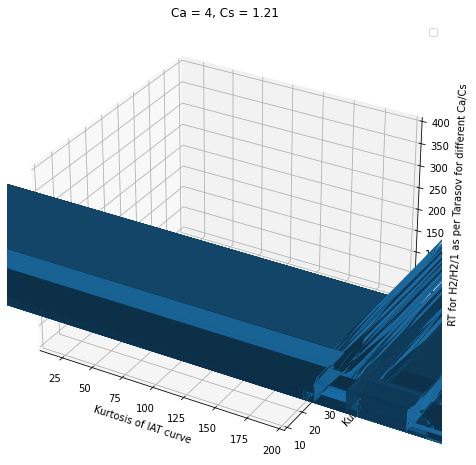

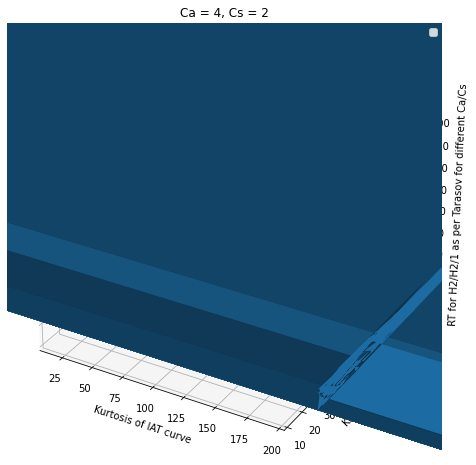

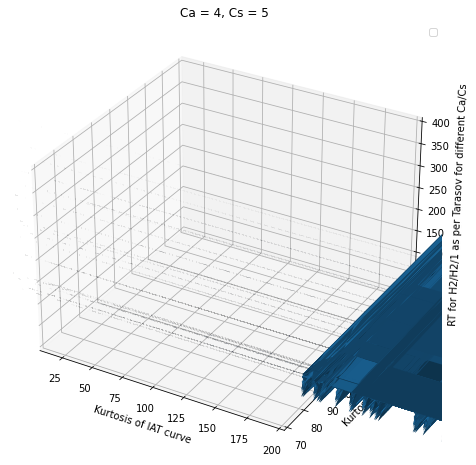

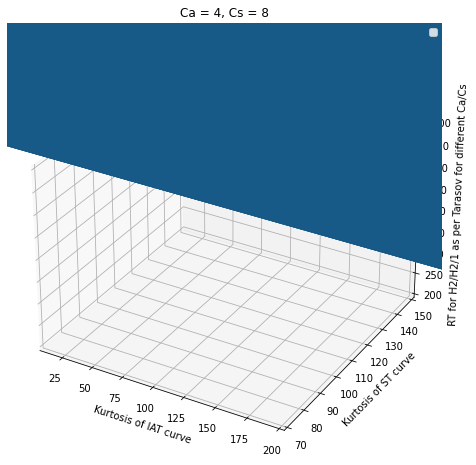

In [60]:
#Fixed IAT, changing ST CV...surface plot
W_exact = []

for coeffST2 in coeffST2_arr :
    
    i = 0
    j = 0
    #For IAT where mean service time is 5
    p_arr= []
    lam1_arr = []
    lam2_arr = []
    lam_kurt_arr = []
    

    q_arr = []
    mu1_arr = []
    mu2_arr = []
    mu_kurt_arr = []
   
    

    while i < 3000 :
        p = np.random.rand()
        lam2 = 0.4*(2.0*p + 1.41421*math.sqrt(-p*(coeffIAT2 - 1.0)*(p - 1.0)) - 2.0)/(coeffIAT2*p + p - 2.0)  
        lam1 = (0.8*p + 0.56568*math.sqrt(p*(-coeffIAT2*p + coeffIAT2 + p - 1.0)))/(coeffIAT2*p - coeffIAT2 + p + 1.0)

        if lam1 <= 0 or lam2 <= 0 :
            continue
        #print("lam1 :",lam1, "lam2 :", lam2, "p :",p)

        q = np.random.rand()*0.5 + 0.5
        mu2 = (2*q + math.sqrt(2)*math.sqrt(-q*(coeffST2 - 1)*(q - 1)) - 2)/(coeffST2*q + q - 2)  # Multiplying by 10 to scale the random numbers between 0 and 20
        mu1 = (2*q + math.sqrt(2)*math.sqrt(q*(-coeffST2*q + coeffST2 + q - 1)))/(coeffST2*q - coeffST2 + q + 1)

        if mu1 <= 0 or mu2 <= 0:
            continue
        
        if calculatecoeff_var(lam1, lam2, p) >=1 and calculatecoeff_var(mu1, mu2, q) >= 1 :
            p_arr.append(p)
            lam1_arr.append(lam1)
            lam2_arr.append(lam2)
            #if calculatecoeff_var(lam1, lam2, p) > 0  :
            lam_kurt_arr.append(compute_kurtosis_H2(lam1, lam2, p))

            q_arr.append(q)
            mu1_arr.append(mu1)
            mu2_arr.append(mu2)
            #if calculatecoeff_var(mu1, mu2, q) > 0  :
            mu_kurt_arr.append(compute_kurtosis_H2(mu1, mu2, q))
        

        i += 1

    
    print("Lengths for parameter vectors of IAT : ", len(p_arr), len(lam1_arr), len(lam2_arr))
    #print(mu_coeff_var_arr)
    W_exact = Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr)
    
    
    X, Y = np.meshgrid(lam_kurt_arr, mu_kurt_arr)
    
    
    
    Z = (np.vstack([W_exact] * 3000).astype(float)).T
    #Z = np.concatenate(Z).astype(None)
    
    
    print(Z.dtype)
    
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot( projection='3d')
    
    #plt.scatter(lam_kurt_arr, W_exact)
    
    if coeffST2 == 1.21 :
        #plt.scatter(mu_kurt_arr, W_exact, color = 'red', label = 'Ca = 4, Cs = 1.21,')
        #ax1.plot_surface(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'red', label = 'Ca = 4, Cs = 1.21,')
        
        ax1.plot_surface(X, Y, Z, facecolor='red')
        ax1.set_title('Ca = 4, Cs = 1.21')
        ax1.set_xlim(10, 200)
        ax1.set_ylim(10,100)
        ax1.set_zlim(0,400)
    elif coeffST2 == 4 :
        #plt.scatter(mu_kurt_arr, W_exact, color = 'blue', label = 'Ca = 4, Cs = 2')
        ax1.plot_surface(X, Y, Z, facecolor='blue')
        ax1.set_title('Ca = 4, Cs = 2')
        ax1.set_xlim(10, 200)
        ax1.set_ylim(10,100)
        ax1.set_zlim(0,400)
    elif coeffST2 == 25 :
        #plt.scatter(mu_kurt_arr, W_exact,  color = 'green', label = 'Ca = 4, Cs = 5')
        #ax1.plot_surface(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'green', label = 'Ca = 4, Cs = 5')
        ax1.plot_surface(X, Y, Z, facecolor='green')
        ax1.set_title('Ca = 4, Cs = 5')
        ax1.set_xlim(10, 200)
        ax1.set_ylim(70,150)
        ax1.set_zlim(0,400)
    elif coeffST2 == 64 :
        #plt.scatter(mu_kurt_arr, W_exact, color = 'yellow', label = 'Ca = 4, Cs = 8')
        #ax1.plot_surface(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'yellow', label = 'Ca = 4, Cs = 8')
        ax1.plot_surface(X, Y, Z, facecolor='yellow')
        ax1.set_title('Ca = 4, Cs = 8')
        ax1.set_xlim(10, 200)
        ax1.set_ylim(70,150)
        ax1.set_zlim(200,600)
        
    plt.legend()

    #plt.xlabel("Kurtosis of ST curve")
    #plt.ylabel("RT for H2/H2/1 as per Tarasov for Ca/Cs ")
    #plt.xlim(10, 250)
    #plt.ylim(0, 200)
    
    
    ax1.set_xlabel('Kurtosis of IAT curve')
    ax1.set_ylabel('Kurtosis of ST curve')
    ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for different Ca/Cs')
    #ax1.set_xlim(10, 200)
    #ax1.set_ylim(10,100)
    #ax1.set_zlim(0,400)

    
print(any(num1 < 0 for num1 in W_exact))
print(any(num2 < 0 for num2 in W_exact))

plt.show()

In [51]:
input_list = [1, 2, 3, 4, 5]

# Convert the list to a NumPy array and reshape it to a 5x5 array
output_array = np.tile(input_list, (5, 1)).T

print("Output array:")
print(output_array)

Output array:
[[1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]
 [5 5 5 5 5]]


Lengths for parameter vectors of IAT :  3000 3000 3000
In order lam1 lam2 p 0.4691677159864527 0.2336170284563572 0.8285013387078619
In order mu1 mu2 q 1.2064540259434475 0.6197369591943394 0.7819269329243255
RT  1.79558942543477
Lengths for parameter vectors of IAT :  3000 3000 3000
In order lam1 lam2 p 1.2465876652511199 0.12465959089509081 0.7648334993587134
In order mu1 mu2 q 1.3273629760788355 0.7013877523031161 0.6331989298326295
RT  3.11070784645599
Lengths for parameter vectors of IAT :  3000 3000 3000
In order lam1 lam2 p 1.5970091192723659 0.023515553862760837 0.9552771509296951
In order mu1 mu2 q 1.2795426102400012 0.6753956703794788 0.68749015150807
RT  12.5769947992346
Lengths for parameter vectors of IAT :  3000 3000 3000
In order lam1 lam2 p 240.74138518045274 0.012287838993903965 0.9693297986901839
In order mu1 mu2 q 1.1281201405752177 0.5196037997013568 0.8905999602811754
RT  54.1055261703382
False
False


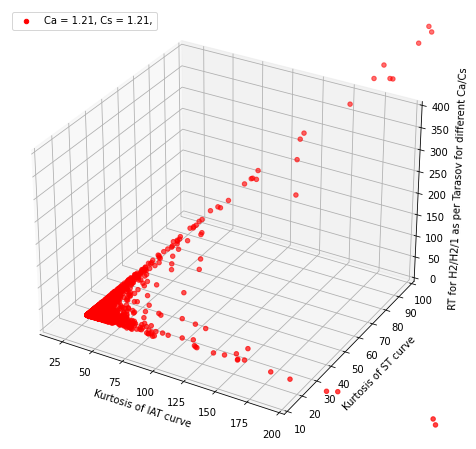

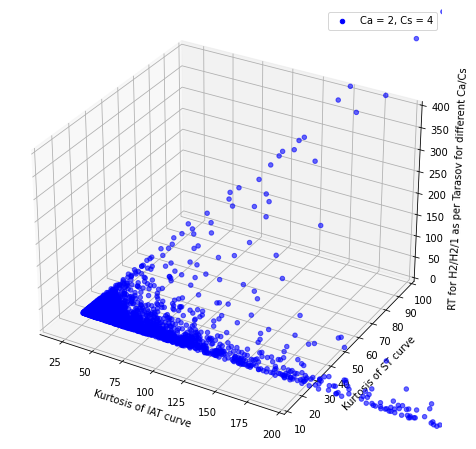

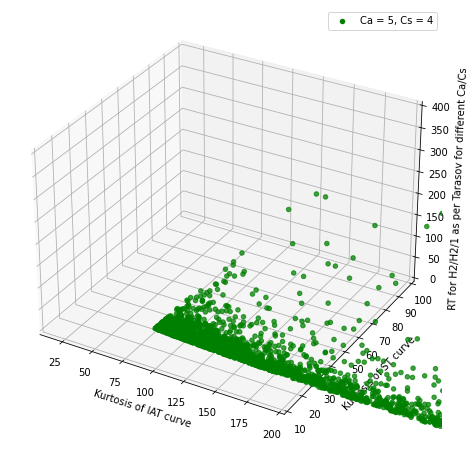

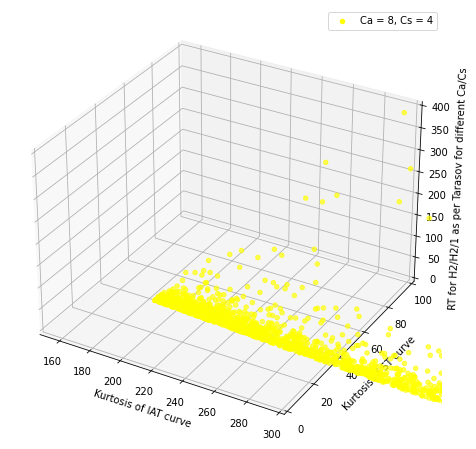

In [54]:
#Fixed ST, changing IAT CV
W_exact = []

for coeffIAT2 in coeffIAT2_arr :
    
    i = 0
    j = 0
    #For IAT where mean service time is 5
    p_arr= []
    lam1_arr = []
    lam2_arr = []
    lam_kurt_arr = []
    

    q_arr = []
    mu1_arr = []
    mu2_arr = []
    mu_kurt_arr = []
   
    

    while i < 3000 :
        p = np.random.rand()
        lam2 = 0.4*(2.0*p + 1.41421*math.sqrt(-p*(coeffIAT2 - 1.0)*(p - 1.0)) - 2.0)/(coeffIAT2*p + p - 2.0)  
        lam1 = (0.8*p + 0.56568*math.sqrt(p*(-coeffIAT2*p + coeffIAT2 + p - 1.0)))/(coeffIAT2*p - coeffIAT2 + p + 1.0)

        if lam1 <= 0 or lam2 <= 0 :
            continue
        #print("lam1 :",lam1, "lam2 :", lam2, "p :",p)

        q = np.random.rand()*0.5 + 0.5
        mu2 = (2*q + math.sqrt(2)*math.sqrt(-q*(coeffST2 - 1)*(q - 1)) - 2)/(coeffST2*q + q - 2)  # Multiplying by 10 to scale the random numbers between 0 and 20
        mu1 = (2*q + math.sqrt(2)*math.sqrt(q*(-coeffST2*q + coeffST2 + q - 1)))/(coeffST2*q - coeffST2 + q + 1)

        if mu1 <= 0 or mu2 <= 0:
            continue
        
        if calculatecoeff_var(lam1, lam2, p) >=1 and calculatecoeff_var(mu1, mu2, q) >= 1 :
            p_arr.append(p)
            lam1_arr.append(lam1)
            lam2_arr.append(lam2)
            #if calculatecoeff_var(lam1, lam2, p) > 0  :
            lam_kurt_arr.append(compute_kurtosis_H2(lam1, lam2, p))

            q_arr.append(q)
            mu1_arr.append(mu1)
            mu2_arr.append(mu2)
            #if calculatecoeff_var(mu1, mu2, q) > 0  :
            mu_kurt_arr.append(compute_kurtosis_H2(mu1, mu2, q))
        

        i += 1

    
    print("Lengths for parameter vectors of IAT : ", len(p_arr), len(lam1_arr), len(lam2_arr))
    #print(mu_coeff_var_arr)
    W_exact = Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr)
    
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot( projection='3d')
    
    #plt.scatter(lam_kurt_arr, W_exact)
    
    if coeffIAT2 == 1.21 :
        #plt.scatter(mu_kurt_arr, W_exact, color = 'red', label = 'Ca = 4, Cs = 1.21,')
        ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'red', label = 'Ca = 1.21, Cs = 4')
        ax1.set_xlim(10, 200)
        ax1.set_ylim(10,100)
        ax1.set_zlim(0,400)
    elif coeffIAT2 == 4 :
        #plt.scatter(mu_kurt_arr, W_exact, color = 'blue', label = 'Ca = 4, Cs = 2')
        ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'blue', label = 'Ca = 2, Cs = 4')
        ax1.set_xlim(10, 200)
        ax1.set_ylim(10,100)
        ax1.set_zlim(0,400)
    elif coeffIAT2 == 25 :
        #plt.scatter(mu_kurt_arr, W_exact,  color = 'green', label = 'Ca = 4, Cs = 5')
        ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'green', label = 'Ca = 5, Cs = 4')
        ax1.set_xlim(10, 200)
        ax1.set_ylim(10,100)
        ax1.set_zlim(0,400)
    elif coeffIAT2 == 64 :
        #plt.scatter(mu_kurt_arr, W_exact, color = 'yellow', label = 'Ca = 4, Cs = 8')
        ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'yellow', label = 'Ca = 8, Cs = 4')
        ax1.set_xlim(150, 300)
        ax1.set_ylim(0,100)
        ax1.set_zlim(0,400)
        
    plt.legend()

    #plt.xlabel("Kurtosis of ST curve")
    #plt.ylabel("RT for H2/H2/1 as per Tarasov for Ca/Cs ")
    #plt.xlim(10, 250)
    #plt.ylim(0, 200)
    
    
    ax1.set_xlabel('Kurtosis of IAT curve')
    ax1.set_ylabel('Kurtosis of ST curve')
    ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for different Ca/Cs')
    #ax1.set_xlim(10, 200)
    #ax1.set_ylim(10,100)
    #ax1.set_zlim(0,400)

    
print(any(num1 < 0 for num1 in W_exact))
print(any(num2 < 0 for num2 in W_exact))

plt.show()

[[-5.   -4.75 -4.5  ...  4.25  4.5   4.75]
 [-5.   -4.75 -4.5  ...  4.25  4.5   4.75]
 [-5.   -4.75 -4.5  ...  4.25  4.5   4.75]
 ...
 [-5.   -4.75 -4.5  ...  4.25  4.5   4.75]
 [-5.   -4.75 -4.5  ...  4.25  4.5   4.75]
 [-5.   -4.75 -4.5  ...  4.25  4.5   4.75]]
[[-5.   -5.   -5.   ... -5.   -5.   -5.  ]
 [-4.75 -4.75 -4.75 ... -4.75 -4.75 -4.75]
 [-4.5  -4.5  -4.5  ... -4.5  -4.5  -4.5 ]
 ...
 [ 4.25  4.25  4.25 ...  4.25  4.25  4.25]
 [ 4.5   4.5   4.5  ...  4.5   4.5   4.5 ]
 [ 4.75  4.75  4.75 ...  4.75  4.75  4.75]]
[[ 0.70886129  0.57562789  0.42921793 ...  0.27541086  0.42921793
   0.57562789]
 [ 0.57562789  0.4208019   0.2570234  ...  0.09046523  0.2570234
   0.4208019 ]
 [ 0.42921793  0.2570234   0.08068791 ... -0.09334004  0.08068791
   0.2570234 ]
 ...
 [ 0.27541086  0.09046523 -0.09334004 ... -0.26940744 -0.09334004
   0.09046523]
 [ 0.42921793  0.2570234   0.08068791 ... -0.09334004  0.08068791
   0.2570234 ]
 [ 0.57562789  0.4208019   0.2570234  ...  0.09046523  0.257023

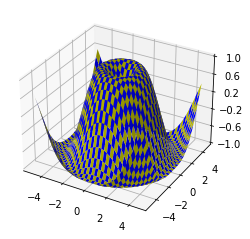

In [55]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.ticker import LinearLocator

ax = plt.figure().add_subplot(projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
xlen = len(X)
Y = np.arange(-5, 5, 0.25)
ylen = len(Y)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

print(X)
print(Y)
print(Z)

# Create an empty array of strings with the same shape as the meshgrid, and
# populate it with two colors in a checkerboard pattern.
colortuple = ('y', 'b')
colors = np.empty(X.shape, dtype=str)
for y in range(ylen):
    for x in range(xlen):
        colors[y, x] = colortuple[(x + y) % len(colortuple)]

# Plot the surface with face colors taken from the array we made.
surf = ax.plot_surface(X, Y, Z, facecolors=colors, linewidth=0)

# Customize the z axis.
ax.set_zlim(-1, 1)
ax.zaxis.set_major_locator(LinearLocator(6))

plt.show()

# Corrected Definition of Kurtosis

In [3]:
import numpy as np
import sympy as sp
import pandas as pd 
import math
from scipy.interpolate import griddata
import matplotlib.pyplot as plt


from sympy import solve, Eq, symbols, re

lam1,lam2 ,p, coeffIAT2 = symbols('lam1 lam2 p coeffIAT2')

coeffIAT2 = 16
coeffST2_arr = [ 1.21, 4, 25, 64]

#coeffIST2 = 16
#coeffIAT2_arr = [ 1.21, 4, 25, 64]

In [11]:
def compute_kurtosis_H2(lam1 , lam2, p) :
    
    moment1 = (p/lam1+ (1-p)/lam2)
    moment2 = (2*p/lam1**2 + 2*(1-p)/lam2**2)
    moment3 = (6*p/lam1**3 + 6*(1-p)/lam2**3)
    moment4 = (24*p/lam1**4 + 24*(1-p)/lam2**4)
    
    kurtosis_num = moment4 - 4*moment1*moment3 + 6*(moment1**2)*moment2 - 3*(moment1**4) 
    kurtosis_deno = (moment2 - moment1**2)**2

    return (kurtosis_num / kurtosis_deno) - 3

In [12]:
print(compute_kurtosis_H2(2.248023, .039512, 0.3))

7.291899092568064


In [125]:
def calculatecoeff_var(lam1, lam2, p) :
    dist_mean =  p/lam1+ (1-p)/lam2
    dist_var = (2*p/lam1**2 + 2*(1-p)/lam2**2) - dist_mean**2
    dist_sd = abs(np.sqrt(dist_var))
    
    if (dist_sd / dist_mean) >= 1 :
        return(dist_sd/dist_mean)
    else :
        print("Please check your inputs. Coefficient of variance < 1")
        return -100

In [126]:
#Implementing the Tarasov H2/H2/1 RT
def Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr) :
    WTarasov_arr = []
    for k in range(min(len(p_arr), len(q_arr))) : 
        a_0 = (lam1_arr[k]*lam2_arr[k])
        a_1 = p_arr[k]*lam1_arr[k] + (1-p_arr[k])*lam2_arr[k]
        b_0 = (mu1_arr[k]*mu2_arr[k])
        b_1 = q_arr[k]*mu1_arr[k] + (1-q_arr[k])*mu2_arr[k]

        c_0 = a_0*b_1 - a_1*b_0 - a_0*(mu1_arr[k]+mu2_arr[k]) + b_0*(lam1_arr[k] + lam2_arr[k])
        c_1 = -a_1*b_1 -a_0 - b_0  + (lam1_arr[k] + lam2_arr[k])*(mu1_arr[k] + mu2_arr[k])
        c_2 = lam1_arr[k] + lam2_arr[k] - mu1_arr[k] - mu2_arr[k]
        
        x = symbols('x')
        expr = x**3-c_2*x**2-c_1*x-c_0


        sol = solve(expr)
        #print(sol)
        
        #calculate wait time in queue Wq
        
        Wq = (-1/re(sol[0])) + (-1/re(sol[1])) - (1/mu1_arr[k]) - (1/mu2_arr[k]) 
        
        #calculate response time in queue W

        W = Wq + (q_arr[k]/mu1_arr[k]+ (1-q_arr[k])/mu2_arr[k])
        WTarasov_arr.append(W)

        if k == 0 :
            print("In order lam1 lam2 p", lam1_arr[k], lam2_arr[k], p_arr[k])
            print("In order mu1 mu2 q", mu1_arr[k], mu2_arr[k], q_arr[k])
            print("RT ", W)

    return WTarasov_arr

# 3D plots fixed IAT, changing ST

Lengths for parameter vectors of IAT :  3000 3000 3000
In order lam1 lam2 p 0.9118343015883437 0.027852680244889284 0.9596823234257962
In order mu1 mu2 q 1.3505963700164851 0.7120023759564543 0.6091014779729049
RT  4.59982482163565
Lengths for parameter vectors of IAT :  3000 3000 3000
In order lam1 lam2 p 1.1147354638760423 0.031502592750517706 0.9480348837621669
In order mu1 mu2 q 34.12972146066249 0.39288461364023125 0.6141855896241288
RT  8.49746143374721
Lengths for parameter vectors of IAT :  3000 3000 3000
In order lam1 lam2 p 2.2480235738935854 0.03951251040930437 0.9173421350305258
In order mu1 mu2 q 1.912741435426536 0.03824500355548807 0.9813775055264919
RT  18.8424695654530
Lengths for parameter vectors of IAT :  3000 3000 3000
In order lam1 lam2 p 1.7150194082000623 0.037101094762056044 0.9273074611505773
In order mu1 mu2 q 2.5143764483731683 0.018761500643582372 0.9886152410103861
RT  31.8247616387027
False
False


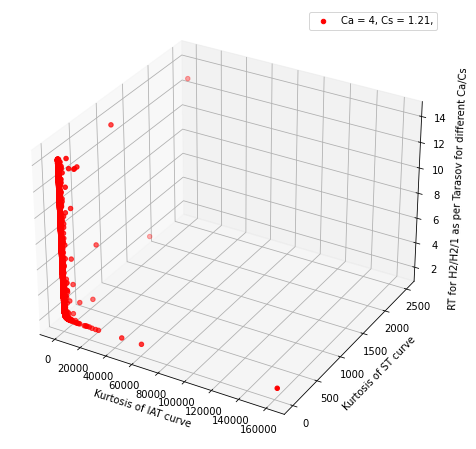

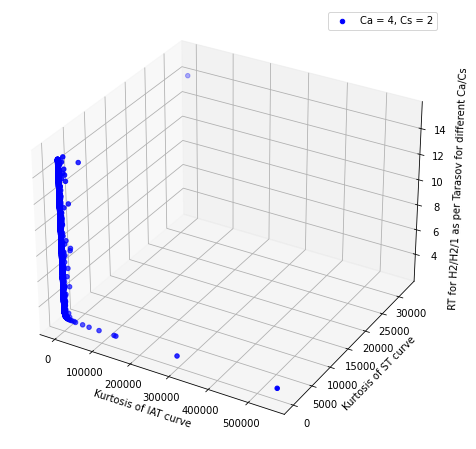

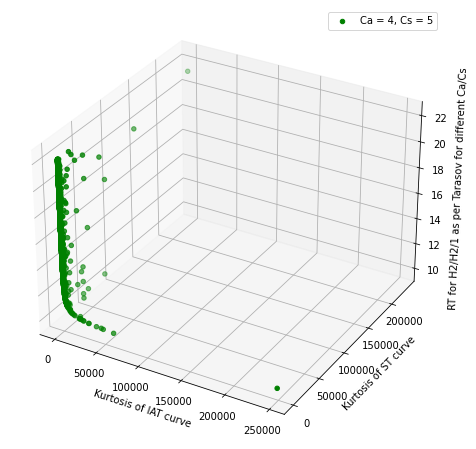

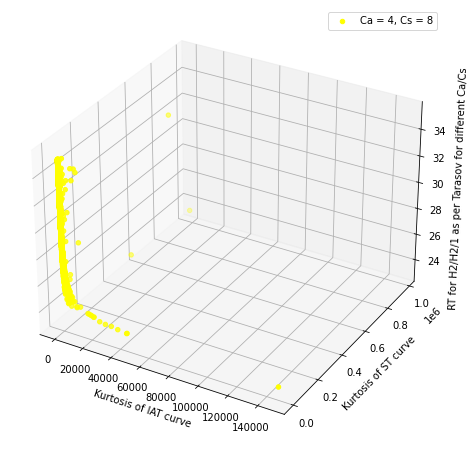

In [127]:
#Fixed IAT, changing ST CV
W_exact = []

final_df = pd.DataFrame(columns = ['coeffIAT_sq', 'coeffST_sq', 'lam_kurt', 'mu_kurt', 'Response time'])
for coeffST2 in coeffST2_arr :
    
    i = 0
    j = 0
    #For IAT where mean service time is 5
    p_arr= []
    lam1_arr = []
    lam2_arr = []
    lam_kurt_arr = []
    

    q_arr = []
    mu1_arr = []
    mu2_arr = []
    mu_kurt_arr = []
   
    

    while i < 3000 :
        p = np.random.rand()
        lam2 = 0.4*(2.0*p + 1.41421*math.sqrt(-p*(coeffIAT2 - 1.0)*(p - 1.0)) - 2.0)/(coeffIAT2*p + p - 2.0)  
        lam1 = (0.8*p + 0.56568*math.sqrt(p*(-coeffIAT2*p + coeffIAT2 + p - 1.0)))/(coeffIAT2*p - coeffIAT2 + p + 1.0)

        if lam1 <= 0 or lam2 <= 0 :
            continue
        #print("lam1 :",lam1, "lam2 :", lam2, "p :",p)

        q = np.random.rand()*0.5 + 0.5
        mu2 = (2*q + math.sqrt(2)*math.sqrt(-q*(coeffST2 - 1)*(q - 1)) - 2)/(coeffST2*q + q - 2)  # Multiplying by 10 to scale the random numbers between 0 and 20
        mu1 = (2*q + math.sqrt(2)*math.sqrt(q*(-coeffST2*q + coeffST2 + q - 1)))/(coeffST2*q - coeffST2 + q + 1)

        if mu1 <= 0 or mu2 <= 0:
            continue
        
        if calculatecoeff_var(lam1, lam2, p) >=1 and calculatecoeff_var(mu1, mu2, q) >= 1 :
            p_arr.append(p)
            lam1_arr.append(lam1)
            lam2_arr.append(lam2)
            #if calculatecoeff_var(lam1, lam2, p) > 0  :
            lam_kurt_arr.append(compute_kurtosis_H2(lam1, lam2, p))

            q_arr.append(q)
            mu1_arr.append(mu1)
            mu2_arr.append(mu2)
            #if calculatecoeff_var(mu1, mu2, q) > 0  :
            mu_kurt_arr.append(compute_kurtosis_H2(mu1, mu2, q))
        

        i += 1

    
    print("Lengths for parameter vectors of IAT : ", len(p_arr), len(lam1_arr), len(lam2_arr))
    #print(mu_coeff_var_arr)
    W_exact = Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr)
    
    store_df = pd.DataFrame({'coeffIAT_sq' : [16] * len(W_exact),
                            'coeffST_sq' : [coeffST2] * len(W_exact),
                            'lam_kurt' : lam_kurt_arr,
                            'mu_kurt' : mu_kurt_arr,
                            'Response time' : W_exact}
                            )
    final_df = final_df.append(store_df, ignore_index = True)
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot( projection='3d')
    
    #plt.scatter(lam_kurt_arr, W_exact)
    
    if coeffST2 == 1.21 :
        #plt.scatter(mu_kurt_arr, W_exact, color = 'red', label = 'Ca = 4, Cs = 1.21,')
        ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'red', label = 'Ca = 4, Cs = 1.21,')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
        
    elif coeffST2 == 4 :
        #plt.scatter(mu_kurt_arr, W_exact, color = 'blue', label = 'Ca = 4, Cs = 2')
        ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'blue', label = 'Ca = 4, Cs = 2')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
        
    elif coeffST2 == 25 :
        #plt.scatter(mu_kurt_arr, W_exact,  color = 'green', label = 'Ca = 4, Cs = 5')
        ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'green', label = 'Ca = 4, Cs = 5')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(70,150)
        #ax1.set_zlim(0,400)
        
    elif coeffST2 == 64 :
        #plt.scatter(mu_kurt_arr, W_exact, color = 'yellow', label = 'Ca = 4, Cs = 8')
        ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'yellow', label = 'Ca = 4, Cs = 8')
        #ax1.set_xlim(100, 200)
        #ax1.set_ylim(100,200)
        #ax1.set_zlim(200,600)
        
        
    plt.legend()

    #plt.xlabel("Kurtosis of ST curve")
    #plt.ylabel("RT for H2/H2/1 as per Tarasov for Ca/Cs ")
    #plt.xlim(10, 250)
    #plt.ylim(0, 200)
    
    
    ax1.set_xlabel('Kurtosis of IAT curve')
    ax1.set_ylabel('Kurtosis of ST curve')
    ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for different Ca/Cs')
    #ax1.set_xlim(10, 200)
    #ax1.set_ylim(10,100)
    #ax1.set_zlim(0,400)

    
print(any(num1 < 0 for num1 in W_exact))
print(any(num2 < 0 for num2 in W_exact))

plt.show()


final_df = final_df.append(store_df, ignore_index = True)
final_df.to_csv('DetailsH2_H2_1_fixedmean_CVa.csv', index= False)

# 3D plots fixed ST, changing IAT   

In [9]:
#Fixed ST, changing IAT CV
W_exact = []

final_df = pd.DataFrame(columns = ['coeffIAT_sq', 'coeffST_sq', 'lam_kurt', 'mu_kurt', 'Response time'])

for coeffIAT2 in coeffIAT2_arr :
    
    i = 0
    j = 0
    #For IAT where mean service time is 5
    p_arr= []
    lam1_arr = []
    lam2_arr = []
    lam_kurt_arr = []
    

    q_arr = []
    mu1_arr = []
    mu2_arr = []
    mu_kurt_arr = []
   
    

    while i < 3000 :
        p = np.random.rand()
        lam2 = 0.4*(2.0*p + 1.41421*math.sqrt(-p*(coeffIAT2 - 1.0)*(p - 1.0)) - 2.0)/(coeffIAT2*p + p - 2.0)  
        lam1 = (0.8*p + 0.56568*math.sqrt(p*(-coeffIAT2*p + coeffIAT2 + p - 1.0)))/(coeffIAT2*p - coeffIAT2 + p + 1.0)

        if lam1 <= 0 or lam2 <= 0 :
            continue
        #print("lam1 :",lam1, "lam2 :", lam2, "p :",p)

        q = np.random.rand()*0.5 + 0.5
        mu2 = (2*q + math.sqrt(2)*math.sqrt(-q*(coeffST2 - 1)*(q - 1)) - 2)/(coeffST2*q + q - 2)  # Multiplying by 10 to scale the random numbers between 0 and 20
        mu1 = (2*q + math.sqrt(2)*math.sqrt(q*(-coeffST2*q + coeffST2 + q - 1)))/(coeffST2*q - coeffST2 + q + 1)

        if mu1 <= 0 or mu2 <= 0:
            continue
        
        if calculatecoeff_var(lam1, lam2, p) >=1 and calculatecoeff_var(mu1, mu2, q) >= 1 :
            p_arr.append(p)
            lam1_arr.append(lam1)
            lam2_arr.append(lam2)
            #if calculatecoeff_var(lam1, lam2, p) > 0  :
            lam_kurt_arr.append(compute_kurtosis_H2(lam1, lam2, p))

            q_arr.append(q)
            mu1_arr.append(mu1)
            mu2_arr.append(mu2)
            #if calculatecoeff_var(mu1, mu2, q) > 0  :
            mu_kurt_arr.append(compute_kurtosis_H2(mu1, mu2, q))
        

        i += 1

    
    print("Lengths for parameter vectors of IAT : ", len(p_arr), len(lam1_arr), len(lam2_arr))
    #print(mu_coeff_var_arr)
    W_exact = Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr)
    
    store_df = pd.DataFrame({'coeffIAT_sq' : [coeffIAT2] * len(W_exact),
                            'coeffST_sq' : [16] * len(W_exact),
                            'lam_kurt' : lam_kurt_arr,
                            'mu_kurt' : mu_kurt_arr,
                            'Response time' : W_exact}
                            )
    final_df = final_df.append(store_df, ignore_index = True)
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot( projection='3d')
    
    #plt.scatter(lam_kurt_arr, W_exact)
    
    if coeffIAT2 == 1.21 :
        #plt.scatter(mu_kurt_arr, W_exact, color = 'red', label = 'Ca = 4, Cs = 1.21,')
        ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'red', label = 'Ca = 1.21, Cs = 4')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
    elif coeffIAT2 == 4 :
        #plt.scatter(mu_kurt_arr, W_exact, color = 'blue', label = 'Ca = 4, Cs = 2')
        ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'blue', label = 'Ca = 2, Cs = 4')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
    elif coeffIAT2 == 25 :
        #plt.scatter(mu_kurt_arr, W_exact,  color = 'green', label = 'Ca = 4, Cs = 5')
        ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'green', label = 'Ca = 5, Cs = 4')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
    elif coeffIAT2 == 64 :
        #plt.scatter(mu_kurt_arr, W_exact, color = 'yellow', label = 'Ca = 4, Cs = 8')
        ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'yellow', label = 'Ca = 8, Cs = 4')
        #ax1.set_xlim(150, 300)
        #ax1.set_ylim(0,100)
        #ax1.set_zlim(0,400)
        
    plt.legend()

    #plt.xlabel("Kurtosis of ST curve")
    #plt.ylabel("RT for H2/H2/1 as per Tarasov for Ca/Cs ")
    #plt.xlim(10, 250)
    #plt.ylim(0, 200)
    
    
    ax1.set_xlabel('Kurtosis of IAT curve')
    ax1.set_ylabel('Kurtosis of ST curve')
    ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for different Ca/Cs')
    #ax1.set_xlim(10, 200)
    #ax1.set_ylim(10,100)
    #ax1.set_zlim(0,400)

    
print(any(num1 < 0 for num1 in W_exact))
print(any(num2 < 0 for num2 in W_exact))

plt.show()


final_df.to_csv('DetailsH2_H2_1_fixedmean_CVs.csv', index= False)

NameError: name 'coeffIAT2_arr' is not defined

# 2D & 3D plots from records (IAT fixed, ST changing)

In [4]:
#IAT fixed, ST changing
df = pd.read_csv('DetailsH2_H2_1_fixedmean_CVa.csv')
df = df.sort_values(by='mu_kurt')


filtered_df_121 = df[df["coeffST_sq"] == 1.21]

lam_kurt_121 = filtered_df_121["lam_kurt"]
mu_kurt_121 = filtered_df_121["mu_kurt"]
RT_121 = filtered_df_121["Response time"]

print(filtered_df_121.head())

filtered_df_4 = df[df["coeffST_sq"] == 4]

lam_kurt_4 = filtered_df_4["lam_kurt"]
mu_kurt_4 = filtered_df_4["mu_kurt"]
RT_4 = filtered_df_4["Response time"]
print(filtered_df_4.head())

filtered_df_25 = df[df["coeffST_sq"] == 25]

lam_kurt_25 = filtered_df_25["lam_kurt"]
mu_kurt_25 = filtered_df_25["mu_kurt"]
RT_25 = filtered_df_25["Response time"]
print(filtered_df_25.head())

filtered_df_64 = df[df["coeffST_sq"] == 64]

lam_kurt_64 = filtered_df_64["lam_kurt"]
mu_kurt_64 = filtered_df_64["mu_kurt"]
RT_64 = filtered_df_64["Response time"]
print(filtered_df_64.head())

      coeffIAT_sq  coeffST_sq    lam_kurt   mu_kurt  Response time
2803           16        1.21   74.574020  9.353002       9.959330
2840           16        1.21  125.901561  9.353038       5.467203
891            16        1.21   48.248066  9.353067      14.224769
1961           16        1.21  283.696402  9.353768       2.860649
823            16        1.21   48.421679  9.354146      14.190804
      coeffIAT_sq  coeffST_sq     lam_kurt    mu_kurt  Response time
4905           16         4.0   721.137664  12.751400       3.657889
3320           16         4.0    59.279428  12.758081      13.484666
3285           16         4.0   375.414934  12.761071       4.353532
5496           16         4.0    49.193345  12.768532      14.999572
4662           16         4.0  2666.445392  12.778777       3.080207
      coeffIAT_sq  coeffST_sq      lam_kurt    mu_kurt  Response time
7108           16        25.0    508.788044  75.124917      14.130651
6718           16        25.0  12687.619026 

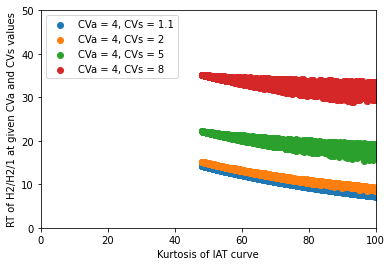

In [184]:
plt.scatter(lam_kurt_121, RT_121, label = 'CVa = 4, CVs = 1.1', marker='o')
plt.scatter(lam_kurt_4, RT_4, label = 'CVa = 4, CVs = 2', marker='o')
plt.scatter(lam_kurt_25, RT_25, label = 'CVa = 4, CVs = 5', marker='o')
plt.scatter(lam_kurt_64, RT_64, label = 'CVa = 4, CVs = 8', marker='o')


plt.xlabel('Kurtosis of IAT curve')
plt.ylabel('RT of H2/H2/1 at given CVa and CVs values')
plt.xlim(0,100)
plt.ylim(0,50)
#plt.ylim(0, 1500)
plt.legend()

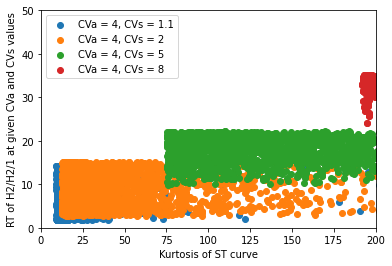

In [185]:
plt.scatter(mu_kurt_121, RT_121, label = 'CVa = 4, CVs = 1.1')
plt.scatter(mu_kurt_4, RT_4, label = 'CVa = 4, CVs = 2')
plt.scatter(mu_kurt_25, RT_25, label = 'CVa = 4, CVs = 5')
plt.scatter(mu_kurt_64, RT_64, label = 'CVa = 4, CVs = 8')


plt.xlabel('Kurtosis of ST curve')
plt.ylabel('RT of H2/H2/1 at given CVa and CVs values')
plt.xlim(0,200)
plt.ylim(0,50)
#plt.ylim(0, 1500)
plt.legend()

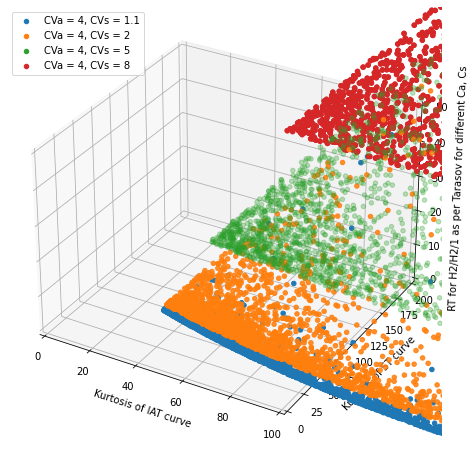

In [186]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot( projection='3d')

ax1.scatter3D(lam_kurt_121, mu_kurt_121, RT_121, label = 'CVa = 4, CVs = 1.1')
ax1.scatter3D(lam_kurt_4, mu_kurt_4, RT_4, label = 'CVa = 4, CVs = 2')
ax1.scatter3D(lam_kurt_25, mu_kurt_25, RT_25, label = 'CVa = 4, CVs = 5')
ax1.scatter3D(lam_kurt_64, mu_kurt_64, RT_64, label = 'CVa = 4, CVs = 8')

ax1.set_xlim(0, 100)
ax1.set_ylim(0,200)
ax1.set_zlim(0,50)


ax1.set_xlabel('Kurtosis of IAT curve')
ax1.set_ylabel('Kurtosis of ST curve')
ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for different Ca, Cs')

plt.legend()
plt.show()

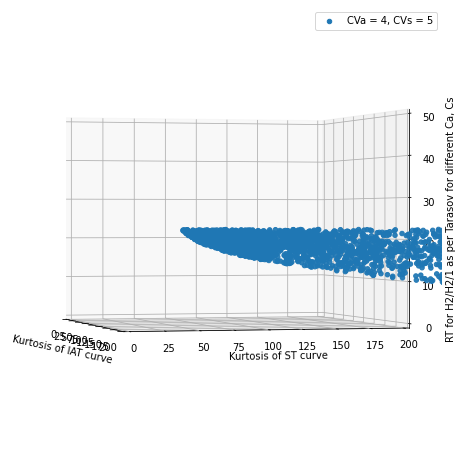

In [191]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot( projection='3d')

#ax1.scatter3D(lam_kurt_121, mu_kurt_121, RT_121, label = 'CVa = 4, CVs = 1.1')
#ax1.scatter3D(lam_kurt_4, mu_kurt_4, RT_4, label = 'CVa = 4, CVs = 2')
ax1.scatter3D(lam_kurt_25, mu_kurt_25, RT_25, label = 'CVa = 4, CVs = 5')
#ax1.scatter3D(lam_kurt_64, mu_kurt_64, RT_64, label = 'CVa = 4, CVs = 8')

ax1.set_xlim(0, 200)
ax1.set_ylim(0,200)
ax1.set_zlim(0,50)
ax1.view_init(elev=0, azim=-15)

ax1.set_xlabel('Kurtosis of IAT curve')
ax1.set_ylabel('Kurtosis of ST curve')
ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for different Ca, Cs')

plt.legend()
plt.show()

In [192]:
!pip3 install ipywidgets
!pip3 install ipympl

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 124 kB 5.1 MB/s            
     |████████████████████████████████| 1.6 MB 33.2 MB/s            
     |████████████████████████████████| 295 kB 34.1 MB/s            


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 511 kB 3.7 MB/s            
     |████████████████████████████████| 510 kB 33.7 MB/s            
     |████████████████████████████████| 508 kB 40.3 MB/s            
     |████████████████████████████████| 508 kB 41.2 MB/s            
     |████████████████████████████████| 507 kB 41.2 MB/s            


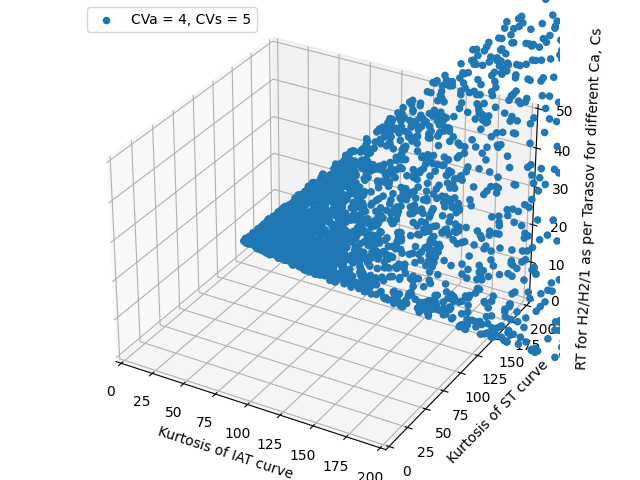

In [7]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure() 
ax1 = Axes3D(fig)

#ax1.scatter3D(lam_kurt_121, mu_kurt_121, RT_121, label = 'CVa = 4, CVs = 1.1')
#ax1.scatter3D(lam_kurt_4, mu_kurt_4, RT_4, label = 'CVa = 4, CVs = 2')
ax1.scatter3D(lam_kurt_25, mu_kurt_25, RT_25, label = 'CVa = 4, CVs = 5')
#ax1.scatter3D(lam_kurt_64, mu_kurt_64, RT_64, label = 'CVa = 4, CVs = 8')

ax1.set_xlim(0, 200)
ax1.set_ylim(0,200)
ax1.set_zlim(0,50)
#ax1.view_init(elev=0, azim=-15)

ax1.set_xlabel('Kurtosis of IAT curve')
ax1.set_ylabel('Kurtosis of ST curve')
ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for different Ca, Cs')

plt.legend()
plt.show()


In [8]:
from ipywidgets import interact
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure() 
ax1 = Axes3D(fig)


def scatter_plot(lam_kurt_25, mu_kurt_25, RT_25) :
    ax1.scatter3D(lam_kurt_25, mu_kurt_25, RT_25, label = 'CVa = 4, CVs = 5')
    ax1.set_xlim(0, 200)
    ax1.set_ylim(0,200)
    ax1.set_zlim(0,50)
    #ax1.view_init(elev=0, azim=-15)

    ax1.set_xlabel('Kurtosis of IAT curve')
    ax1.set_ylabel('Kurtosis of ST curve')
    ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for different Ca, Cs')

    plt.legend()
    plt.show()
    
interact(scatter_plot, lam_kurt_25=list(lam_kurt_25), mu_kurt_25=list(mu_kurt_25), RT_25=list(RT_25))
    

interactive(children=(Dropdown(description='lam_kurt_25', options=(508.78804419792436, 12687.619025630127, 69.…

<function __main__.scatter_plot(lam_kurt_25, mu_kurt_25, RT_25)>

# 2D & 3D plots from records (ST fixed, IAT changing)

In [149]:
#ST fixed, IAT changing
df = pd.read_csv('DetailsH2_H2_1_fixedmean_CVs.csv')
df = df.sort_values(by='lam_kurt')


filtered_df_121 = df[df["coeffIAT_sq"] == 1.21]

lam_kurt_121 = filtered_df_121["lam_kurt"]
mu_kurt_121 = filtered_df_121["mu_kurt"]
RT_121 = filtered_df_121["Response time"]

print(filtered_df_121.head())

filtered_df_4 = df[df["coeffIAT_sq"] == 4]

lam_kurt_4 = filtered_df_4["lam_kurt"]
mu_kurt_4 = filtered_df_4["mu_kurt"]
RT_4 = filtered_df_4["Response time"]
print(filtered_df_4.head())

filtered_df_25 = df[df["coeffIAT_sq"] == 25]

lam_kurt_25 = filtered_df_25["lam_kurt"]
mu_kurt_25 = filtered_df_25["mu_kurt"]
RT_25 = filtered_df_25["Response time"]
print(filtered_df_25.head())

filtered_df_64 = df[df["coeffIAT_sq"] == 64]

lam_kurt_64 = filtered_df_64["lam_kurt"]
mu_kurt_64 = filtered_df_64["mu_kurt"]
RT_64 = filtered_df_64["Response time"]
print(filtered_df_64.head())

      coeffIAT_sq  coeffST_sq   lam_kurt     mu_kurt  Response time
2464         1.21          16  15.234961  192.108728      22.829724
1358         1.21          16   9.313547  192.156914      22.834772
1645         1.21          16   9.632733  192.185125      22.834314
2495         1.21          16  11.949967  192.188620      22.831528
2797         1.21          16  11.367136  192.308210      22.832134
      coeffIAT_sq  coeffST_sq    lam_kurt     mu_kurt  Response time
4172          4.0          16   43.386717  192.257954      24.944188
3453          4.0          16  124.796895  192.304679      24.686389
5285          4.0          16   20.598048  192.307572      25.086822
4710          4.0          16   45.787652  192.350567      24.932417
5542          4.0          16  282.138808  192.396351      24.441896
      coeffIAT_sq  coeffST_sq    lam_kurt     mu_kurt  Response time
6982         25.0          16  119.431794  192.067352      40.562919
8732         25.0          16  154.39428

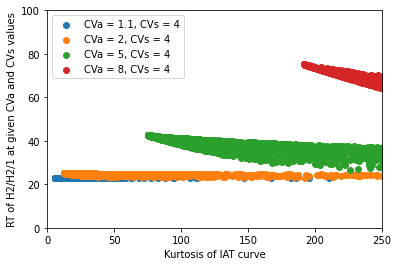

In [154]:
plt.scatter(lam_kurt_121, RT_121, label = 'CVa = 1.1, CVs = 4', marker='o')
plt.scatter(lam_kurt_4, RT_4, label = 'CVa = 2, CVs = 4', marker='o')
plt.scatter(lam_kurt_25, RT_25, label = 'CVa = 5, CVs = 4', marker='o')
plt.scatter(lam_kurt_64, RT_64, label = 'CVa = 8, CVs = 4', marker='o')


plt.xlabel('Kurtosis of IAT curve')
plt.ylabel('RT of H2/H2/1 at given CVa and CVs values')
plt.xlim(0,250)
plt.ylim(0,100)
#plt.ylim(0, 1500)
plt.legend()

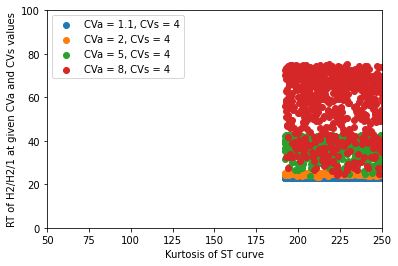

In [156]:
plt.scatter(mu_kurt_121, RT_121, label = 'CVa = 1.1, CVs = 4')
plt.scatter(mu_kurt_4, RT_4, label = 'CVa = 2, CVs = 4')
plt.scatter(mu_kurt_25, RT_25, label = 'CVa = 5, CVs = 4')
plt.scatter(mu_kurt_64, RT_64, label = 'CVa = 8, CVs = 4')


plt.xlabel('Kurtosis of ST curve')
plt.ylabel('RT of H2/H2/1 at given CVa and CVs values')
plt.xlim(50,250)
plt.ylim(0,100)
#plt.ylim(0, 1500)
plt.legend()

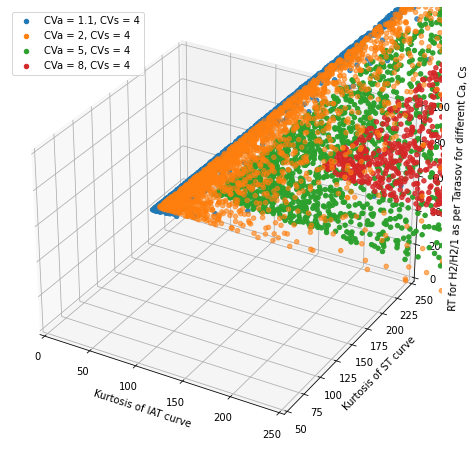

In [157]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot( projection='3d')

ax1.scatter3D(lam_kurt_121, mu_kurt_121, RT_121, label = 'CVa = 1.1, CVs = 4')
ax1.scatter3D(lam_kurt_4, mu_kurt_4, RT_4, label = 'CVa = 2, CVs = 4')
ax1.scatter3D(lam_kurt_25, mu_kurt_25, RT_25, label = 'CVa = 5, CVs = 4')
ax1.scatter3D(lam_kurt_64, mu_kurt_64, RT_64, label = 'CVa = 8, CVs = 4')

ax1.set_xlim(0, 250)
ax1.set_ylim(50,250)
ax1.set_zlim(0,100)


ax1.set_xlabel('Kurtosis of IAT curve')
ax1.set_ylabel('Kurtosis of ST curve')
ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for different Ca, Cs')

plt.legend()
plt.show()

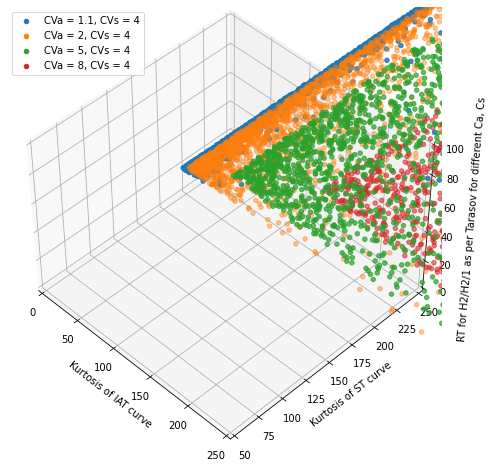

In [158]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot( projection='3d')

ax1.scatter3D(lam_kurt_121, mu_kurt_121, RT_121, label = 'CVa = 1.1, CVs = 4')
ax1.scatter3D(lam_kurt_4, mu_kurt_4, RT_4, label = 'CVa = 2, CVs = 4')
ax1.scatter3D(lam_kurt_25, mu_kurt_25, RT_25, label = 'CVa = 5, CVs = 4')
ax1.scatter3D(lam_kurt_64, mu_kurt_64, RT_64, label = 'CVa = 8, CVs = 4')

ax1.set_xlim(0, 250)
ax1.set_ylim(50,250)
ax1.set_zlim(0,100)
ax1.view_init(elev=45, azim=-45)


ax1.set_xlabel('Kurtosis of IAT curve')
ax1.set_ylabel('Kurtosis of ST curve')
ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for different Ca, Cs')

plt.legend()
plt.show()

# Filtering out ever so close values in kurt (lam and mu)

# IAT fixed, ST changing

In [170]:
#IAT fixed, ST changing

df = pd.read_csv('DetailsH2_H2_1_fixedmean_CVa.csv')
df.iloc[:, :-1] = df.iloc[:, :-1].apply(lambda x: x.astype(int))
df_unique_lam = df.drop_duplicates(subset='lam_kurt')
df_unique_mu = df.drop_duplicates(subset='mu_kurt')

df_unique_lam = df_unique_lam.sort_values(by='lam_kurt')
df_unique_mu = df_unique_mu.sort_values(by='mu_kurt')

print(df_unique_lam.head())
print(df_unique_mu.head())

     coeffIAT_sq  coeffST_sq  lam_kurt  mu_kurt  Response time
11            16           1        48        9      14.137238
129           16           1        49       12      14.017934
111           16           1        50       13      13.761001
3             16           1        51       10      13.597806
7             16           1        52        9      13.435783
    coeffIAT_sq  coeffST_sq  lam_kurt  mu_kurt  Response time
2            16           1       124        9       5.544359
0            16           1       146       10       4.599825
29           16           1        62       11      11.709641
4            16           1        53       12      13.158144
15           16           1        96       13       7.545368


In [171]:
filtered_df_121 = df_unique_lam[df_unique_lam["coeffST_sq"] == 1.21]

lam_kurt_121 = filtered_df_121["lam_kurt"]
mu_kurt_121 = filtered_df_121["mu_kurt"]
RT_121 = filtered_df_121["Response time"]

print(filtered_df_121.head())

filtered_df_4 = df_unique_lam[df_unique_lam["coeffST_sq"] == 4]

lam_kurt_4 = filtered_df_4["lam_kurt"]
mu_kurt_4 = filtered_df_4["mu_kurt"]
RT_4 = filtered_df_4["Response time"]
print(filtered_df_4.head())

filtered_df_25 = df_unique_lam[df_unique_lam["coeffST_sq"] == 25]

lam_kurt_25 = filtered_df_25["lam_kurt"]
mu_kurt_25 = filtered_df_25["mu_kurt"]
RT_25 = filtered_df_25["Response time"]
print(filtered_df_25.head())

filtered_df_64 = df_unique_lam[df_unique_lam["coeffST_sq"] == 64]

lam_kurt_64 = filtered_df_64["lam_kurt"]
mu_kurt_64 = filtered_df_64["mu_kurt"]
RT_64 = filtered_df_64["Response time"]
print(filtered_df_64.head())

Empty DataFrame
Columns: [coeffIAT_sq, coeffST_sq, lam_kurt, mu_kurt, Response time]
Index: []
      coeffIAT_sq  coeffST_sq  lam_kurt  mu_kurt  Response time
3091           16           4       170       14       6.377733
3104           16           4       204       30       5.598908
4918           16           4       208      276       5.142609
3520           16           4       240       21       5.192188
3525           16           4       244       38       5.086423
      coeffIAT_sq  coeffST_sq  lam_kurt  mu_kurt  Response time
6522           16          25       312      275      14.426253
6280           16          25       327      175      14.677757
8371           16          25       364       91      14.843445
7705           16          25       380       87      14.761372
8812           16          25       384       98      14.674663
       coeffIAT_sq  coeffST_sq  lam_kurt  mu_kurt  Response time
9897            16          64       298      523      29.460569
10090  

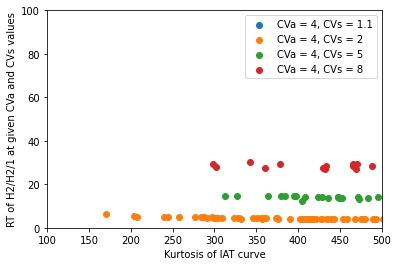

In [172]:
plt.scatter(lam_kurt_121, RT_121, label = 'CVa = 4, CVs = 1.1', marker='o')
plt.scatter(lam_kurt_4, RT_4, label = 'CVa = 4, CVs = 2', marker='o')
plt.scatter(lam_kurt_25, RT_25, label = 'CVa = 4, CVs = 5', marker='o')
plt.scatter(lam_kurt_64, RT_64, label = 'CVa = 4, CVs = 8', marker='o')


plt.xlabel('Kurtosis of IAT curve')
plt.ylabel('RT of H2/H2/1 at given CVa and CVs values')
plt.xlim(100,500)
plt.ylim(0,100)
#plt.ylim(0, 1500)
plt.legend()

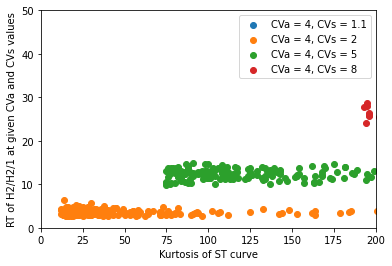

In [173]:
plt.scatter(mu_kurt_121, RT_121, label = 'CVa = 4, CVs = 1.1')
plt.scatter(mu_kurt_4, RT_4, label = 'CVa = 4, CVs = 2')
plt.scatter(mu_kurt_25, RT_25, label = 'CVa = 4, CVs = 5')
plt.scatter(mu_kurt_64, RT_64, label = 'CVa = 4, CVs = 8')


plt.xlabel('Kurtosis of ST curve')
plt.ylabel('RT of H2/H2/1 at given CVa and CVs values')
plt.xlim(0,200)
plt.ylim(0,50)
#plt.ylim(0, 1500)
plt.legend()

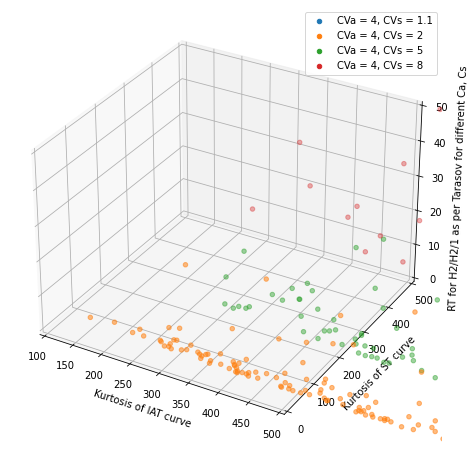

In [176]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot( projection='3d')

ax1.scatter3D(lam_kurt_121, mu_kurt_121, RT_121, label = 'CVa = 4, CVs = 1.1')
ax1.scatter3D(lam_kurt_4, mu_kurt_4, RT_4, label = 'CVa = 4, CVs = 2')
ax1.scatter3D(lam_kurt_25, mu_kurt_25, RT_25, label = 'CVa = 4, CVs = 5')
ax1.scatter3D(lam_kurt_64, mu_kurt_64, RT_64, label = 'CVa = 4, CVs = 8')

ax1.set_xlim(100, 500)
ax1.set_ylim(0,500)
ax1.set_zlim(0,50)


ax1.set_xlabel('Kurtosis of IAT curve')
ax1.set_ylabel('Kurtosis of ST curve')
ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for different Ca, Cs')

plt.legend()
plt.show()